## Seam Carving
### Content Aware Resizing - An application of Seam Carving.

[Seam Carving](https://en.wikipedia.org/wiki/Seam_carving) is an algorithm for content-aware image resizing.

It functions by establishing a number of seams (paths of least importance) in an image and automatically removes seams to reduce image size or inserts seams to extend it. Seam carving also allows manually defining areas in which pixels may not be modified, and features the ability to remove whole objects from photographs.

|Original | Scaling | Croping | Seam Carving | 
|:-------:|:-------:|:-------:|:------------:|
|![Original](https://upload.wikimedia.org/wikipedia/commons/c/cb/Broadway_tower_edit.jpg) |![Scaling](https://upload.wikimedia.org/wikipedia/commons/a/a3/Broadway_tower_edit_scale.png)|![Croping](https://upload.wikimedia.org/wikipedia/commons/e/ef/Broadway_tower_edit_cropped.png)|![Seam Carving](https://upload.wikimedia.org/wikipedia/commons/e/ed/Broadway_tower_edit_Seam_Carving.png)|

#### Computing seams
Computing a seam consists of finding a path of minimum energy cost from one end of the image to another.

To do this we use Dynamic Programming

#### Setup code

In [21]:
from scipy.signal import convolve2d
from PIL import Image
import numpy as np
from ipywidgets import interact

def pixelList(image):
    inPixels = image.copy().load()
    outPixels = []
    width, height = image.size
    for i in range(height):
        outPixels.append([])
        for j in range(width):
            outPixels[i].append(inPixels[j, i])
    return outPixels

# Draw seam at index
def drawSeam(index, outPixels):
    for i in range(height):
        nextDir = index + directions[i][index]
        outPixels[i][index] = (255, 255, 255)
        
        if nextDir > width - 1:
            index = width - 1
        elif nextDir < 0:
            index = 0
        else:
            index = nextDir

# Carve seam at index
def removeSeam(index):
    for i in range(height):
        nextDir = index + directions[i][index]
        removed[i].append({
            "pixel" : outPixels[i].pop(index),
            "energy": energyPixels[i].pop(index),
            "direction": directions[i].pop(index) 
        })
        
        if nextDir > width - 1:
            index = width - 1
        elif nextDir < 0:
            index = 0
        else:
            index = nextDir

def addSean(seam):
    return

# Concatenate images horizontally
def concat_h(img1, img2):
    result = Image.new('RGB', (2 * img1.width + 10, img1.height))
    result.paste(img1, (0, 0))
    result.paste(img2, (img1.width + 10, 0))
    return result

# Concatenate images vertically
def concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

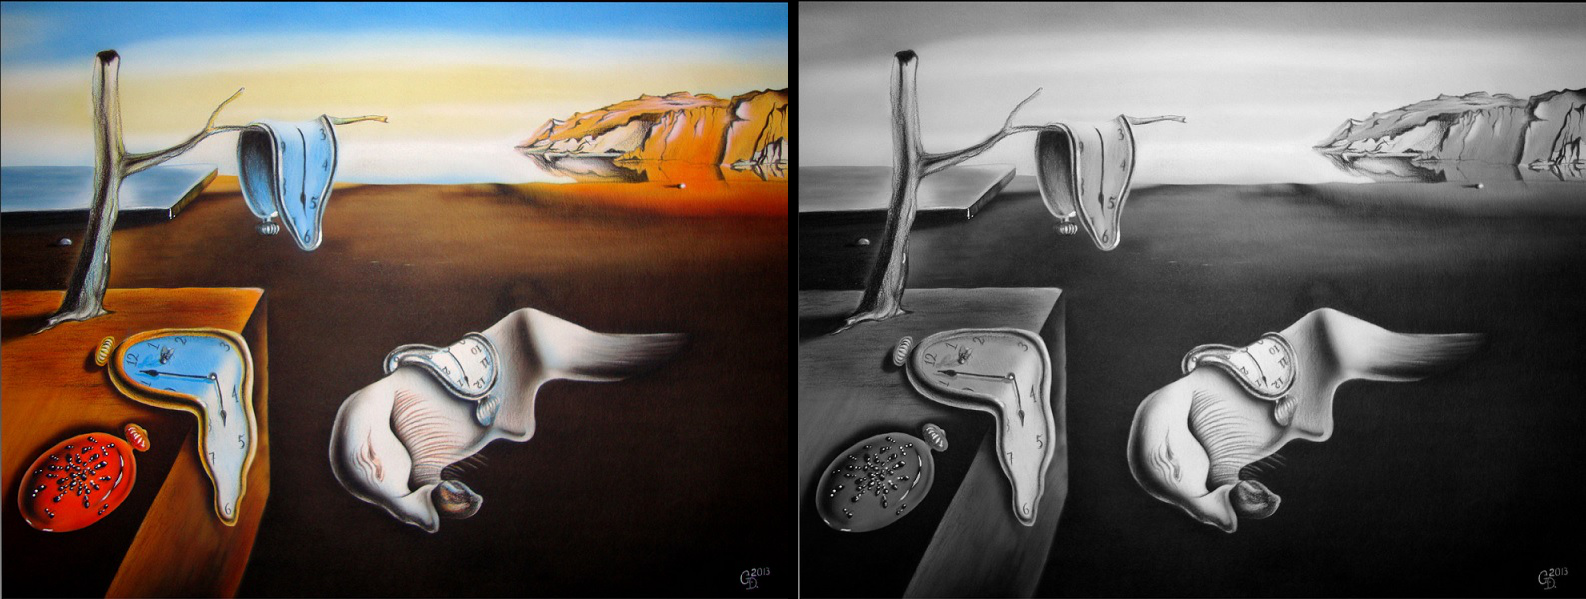

In [22]:
# Open image
img = Image.open("./sampleImages/clocks.jpg")
width, height = img.size

# Convert to greyscale
grey = img.convert("L")

concat_h(img, grey)

#### Edge Detection

To detect edges in the image we [convolve](https://en.wikipedia.org/wiki/Convolution) the [Sobel Operators](https://en.wikipedia.org/wiki/Sobel_operator) with the pixels of the image.

![Sobel Operators](https://wikimedia.org/api/rest_v1/media/math/render/svg/848abd56e0e33cf402f01183bfe1f68a93fb34a9)

![Result](https://wikimedia.org/api/rest_v1/media/math/render/svg/23ae6772c5f58751fc6014b71d6adafb30a31c79)

In [23]:
# Edge detection
edge = 0
pixels = np.array(grey)

# Sobel operators
Gx = np.array([[-1,  0,  1],
               [-2,  0,  2],
               [-1,  0,  1]])

Gy = np.array([[-1, -2, -1],
               [ 0,  0,  0],
               [ 1,  2,  1]])
                
@interact(xFact=((1 / 50), 1), yFact=((1 / 50), 1))
def edgeDetection(xFact=1/10, yFact=1/10):
    global edge

    dx = convolve2d(pixels, Gx * xFact, mode="full", boundary="symm")
    dy = convolve2d(pixels, Gy * yFact, mode="full", boundary="symm")

    mag = np.sqrt(dx ** 2 + dy ** 2)

    # Normalise to (0, 255)
    mag = np.clip(mag, 0, 255)

    edge = Image.fromarray(np.array(mag, dtype=np.uint8))

    # Remove padding added during convolution
    edge = edge.crop((1, 1, width + 1, height + 1))

    display(concat_h(grey, edge))

interactive(children=(FloatSlider(value=0.1, description='xFact', max=1.0, min=0.02), FloatSlider(value=0.1, d…

#### Energy Map

Energy or weight here is defined as the edginess of the image.

It is a map of the least amount of energy required to reach the bottom from that point.

White is higher energy and black is lower energy.

Seams would avoid touching the white areas as much as possible.

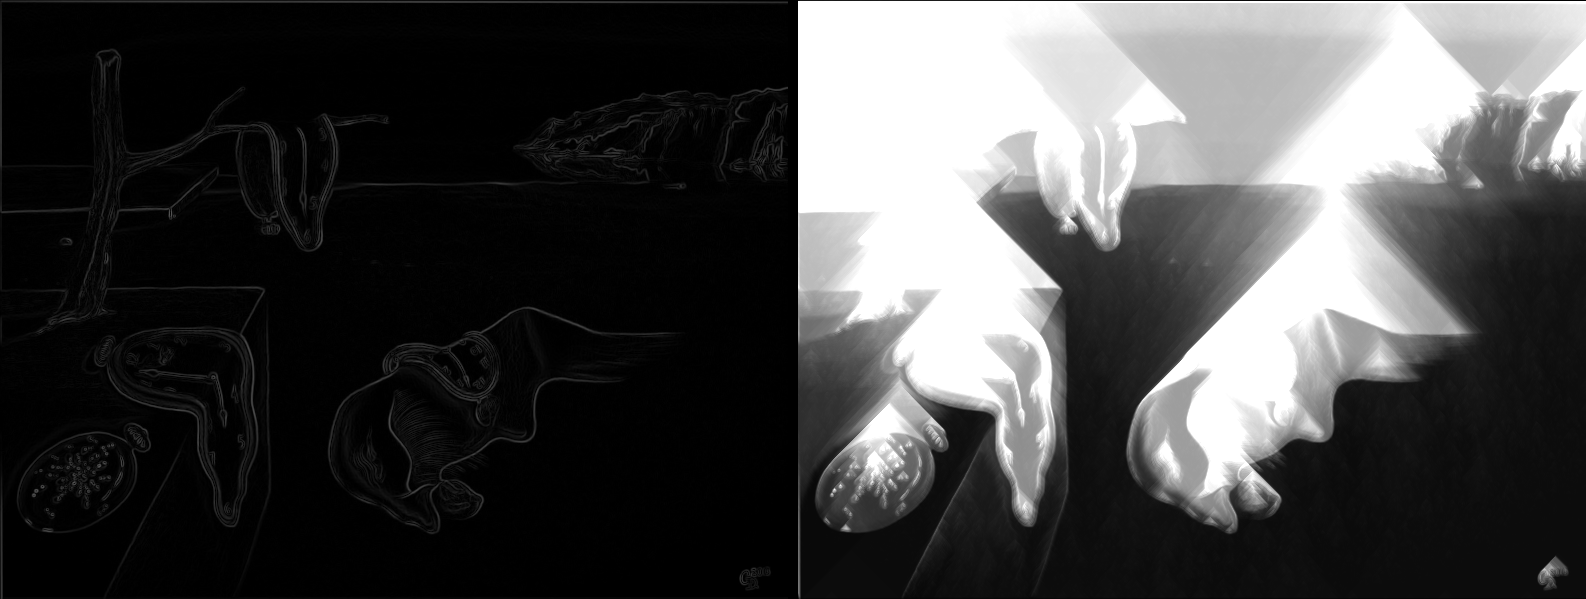

In [24]:
# Energy map
energyMap = edge.copy()
energyPixels = energyMap.load()

width, height = energyMap.size

# Directions (Lookup table)
directions = []
for i in range(height):
    directions.append([])
    for j in range(width):
        directions[i].append(0)

# Compute energies
for i in range(height - 2, 0, -1):
    for j in range(width):
        energies = [energyPixels[max(0, j - 1), i + 1], energyPixels[j, i + 1], energyPixels[min(j + 1, width - 1), i + 1]]
        minEnergy = min(energies)
        energyPixels[j, i] += minEnergy
        # (0, 1, 2) - 1 -> (-1. 0, 1)
        directions[i][j] = energies.index(minEnergy) - 1

concat_h(edge, energyMap)

#### Directions Visualized

The directions the seam should follow at each point.

* Black - Straight down
* White - Down right
* Grey  - Down left

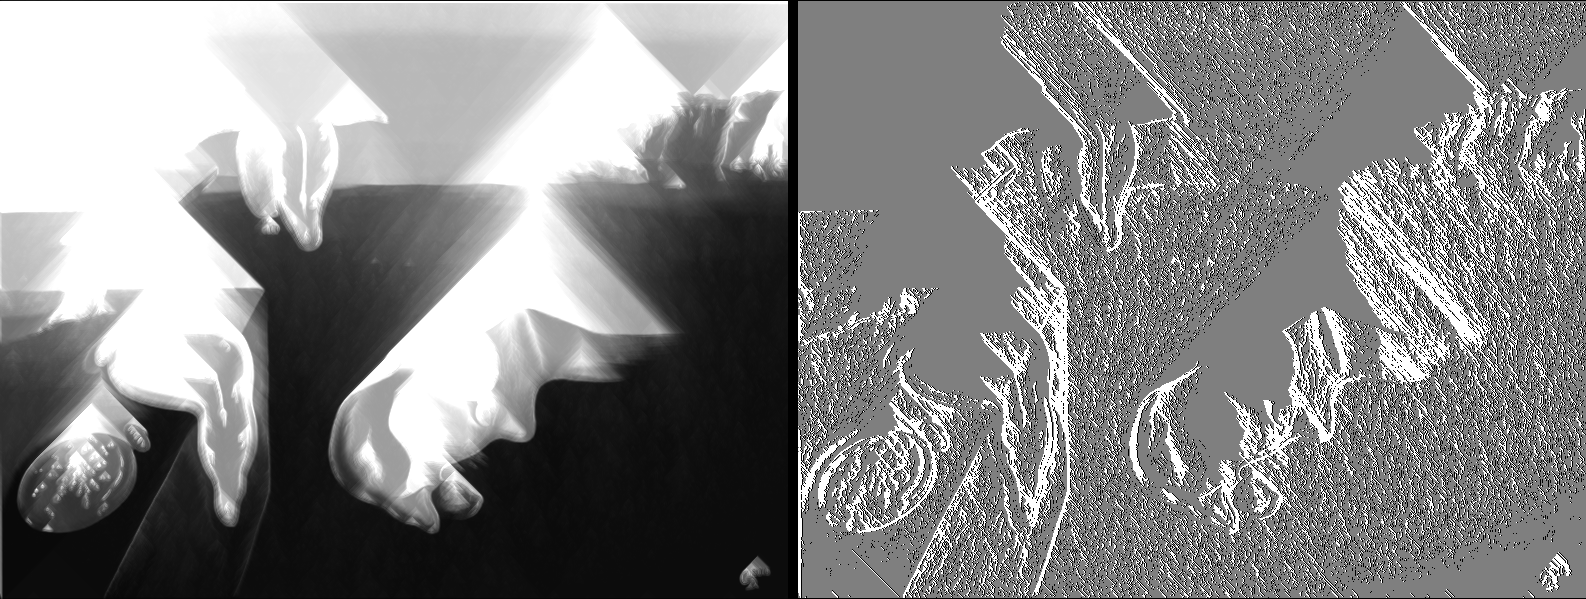

In [25]:
# Visualize directions
dirVisPixels = []
for i in range(height):
    dirVisPixels.append([])
    for j in range(width):
        dirVisPixels[i].append([127, 0, 255][directions[i][j] + 1])

dirVisPixels = np.array(dirVisPixels, dtype=np.uint8)
dirVis = Image.fromarray(dirVisPixels)

concat_h(energyMap, dirVis)

#### Seams Visualized

In [26]:
@interact(n=(0, width - 1, 1))
def seamVis(n=1):
    outPixels = pixelList(img)
    drawSeam(n, outPixels)
    out = Image.fromarray(np.array(outPixels, dtype=np.uint8))
    display(concat_h(img, out))

interactive(children=(IntSlider(value=1, description='n', max=787), Output()), _dom_classes=('widget-interact'…

#### Seam Caving

In [27]:
# Output image
outPixels = pixelList(img)

# Removed pixels
removed = []
for i in range(height):
    removed.append([])

energyPixels = pixelList(energyMap)

seamsRemoved = 0

@interact(n=(0, 200, 1))
def resize(n=0):
    global seamsRemoved

    if n > seamsRemoved:
        for i in range(n - seamsRemoved):
            minEnergy = min(energyPixels[0])
            index = energyPixels[0].index(minEnergy)
            removeSeam(index)
        seamsRemoved = n

    elif n > seamsRemoved:
        addSean(None)   
    
    out = Image.fromarray(np.array(outPixels, dtype=np.uint8))
    display(concat_h(img, out))

interactive(children=(IntSlider(value=0, description='n', max=200), Output()), _dom_classes=('widget-interact'…

#### References

* [Harvard CS50 - Dynamic Programming](https://youtu.be/0y5UkZc-C8Y)
* [MIT - Introduction to Computational Thinking](https://computationalthinking.mit.edu/Fall20/lecture3/)